# LED Pulse Data vs Temperature: Feb 15+16, 2023
## Import the libraries

In [2]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from scipy.stats import norm

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf

In [3]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Gather the metadata from summary files

In [4]:
datapath = '/data/USRP_Laser_TempScan_Data'
days     = ["20230215","20230216"]

metadata = {}

for day in days:
    metadata[day] = pd.read_csv(os.path.join(os.path.join(datapath, day),day+"_run_temperatures.csv"),
                                names=["series","T target","T start","T final"])

In [5]:
### Need to add a powers column because I didn't do this in the first acquisition script
for day in days:
    metadata[day]["power"] = [-40,-35,-30]*int(len(metadata[day]["series"])/3)
    
metadata[days[1]]["power"][int(metadata[days[1]].loc[metadata[days[1]]["series"]=="20230216_071116"].index[0]):] = -30

<ipython-input-5-d9ab958507fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[days[1]]["power"][int(metadata[days[1]].loc[metadata[days[1]]["series"]=="20230216_071116"].index[0]):] = -30
/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
## Put the dataframes together, call it metadata
metadata = pd.concat([metadata[day] for day in days], axis=0)
# metadata

In [7]:
## Once dataframe is finished, clean up the bad temperature readings
metadata["T start"].loc[metadata["T start"] == -99990.000] = np.nan
metadata["T final"].loc[metadata["T final"] == -99990.000] = np.nan
# metadata

/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,series,T target,T start,T final,power
0,20230215_125136,0.015,15.0020,14.9982,-40
1,20230215_131026,0.015,14.9972,14.9998,-35
2,20230215_132909,0.015,14.9975,NaN,-30
3,20230215_135027,0.025,25.0586,24.9925,-40
4,20230215_140911,0.025,24.9950,25.0078,-35
5,20230215_142755,0.025,25.0008,25.0071,-30
6,20230215_144842,0.050,50.3424,49.9906,-40
7,20230215_150727,0.050,50.0019,49.9889,-35
8,20230215_152611,0.050,50.0088,49.9987,-30
9,20230215_155611,0.075,75.0066,75.0065,-40


## Decide which files to look at

In [10]:
power_choice  = -35
runs_metadata = metadata.loc[metadata["power"]==power_choice]
series_list   = runs_metadata["series"].values

runs_metadata

,series,T target,T start,T final,power
1,20230215_131026,0.015,14.9972,14.9998,-35
4,20230215_140911,0.025,24.9950,25.0078,-35
7,20230215_150727,0.050,50.0019,49.9889,-35
10,20230215_161458,0.075,75.0158,75.0251,-35
13,20230215_171730,0.100,100.0280,NaN,-35
16,20230215_182005,0.125,125.0240,124.9520,-35
19,20230215_192344,0.150,150.0360,150.0180,-35
22,20230215_202932,0.175,175.0540,175.0250,-35
25,20230215_213255,0.200,199.8360,200.1580,-35
28,20230215_223419,0.225,225.1180,224.9420,-35


## Representative File

In [21]:
rep_idx = 0
series  = series_list[rep_idx]

In [ ]:
sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

for f in nse_files:
    print(f)

## Load the summary file

In [12]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power'] + md['tx_gain']
print("RF Power at USRP:", rf_power, "dBm")

for i in np.arange(len(nse_files)):
    print(nse_files[i].split("/")[-1].split(".")[0],charZs[i])
    print(charFs[i])

RF Power at USRP: -35 dBm
USRP_Noise_20230215_131026_delta0 [0.01264658+0.00838383j 0.01214033+0.00921234j 0.01177486+0.0101058j ]
[4241.986128 4241.986927 4241.987726]
USRP_Noise_20230215_131026_delta0_2 [0.01269689+0.00851291j 0.01218234+0.00937166j 0.01185491+0.01025638j]
[4241.986128 4241.986927 4241.987726]


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [13]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")
print("Vmin = ",np.min(voltages), "V")
print("Vmax = ",np.max(voltages), "V")
# print("Vstep = ",int((voltages[1]-voltages[0])*1e3), "mV")

4 4 <-- These should be the same
Vmin =  2.0 V
Vmax =  5.0 V


### Define some PSD parameters

In [14]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [15]:
## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
        pulse_w     = md[k]['LEDpulseus'][0]
        delay_ms    = md[k]['delayms'][0]
        break
print("Pulse f: ",LED_rate_Hz,"Hz")
print("Pls wdth:",pulse_w,"us")
print("Duration:",lapse_sec,"sec")
print("P  delay:",delay_ms,"ms")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f:  10.0 Hz
Pls wdth: 1.0 us
Duration: 200.0 sec
P  delay: 5.0 ms
Total pulse windows: 2000.0
Time between pulse arrival: 0.1 sec
Number of windows to look at: 1800


## Noise cleaning to get cleaning coefficients

In [16]:
# %matplotlib notebook

Will separate data into  150 chunks to achieve the requested 1.00e+01  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
saving pulses to /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_Noise_20230215_131026_delta0.h5!
found 6 pulses
chunk length plugged into welch is 5000
chunked data into 150 timestreams
computed electronics basis
cleaning...
number of chunks used to average is 129
Converting to resonator basis!
Fr from fit  [GHz]: 4241.986951704465
Fr min curve [GHz]: 4241.986576828841
Fr from fit  [GHz]: 4241.986951704465
Fr min curve [GHz]: 4241.986576828841
Will separate data into  150 chunks to achieve the requested 1.00e+01  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decima

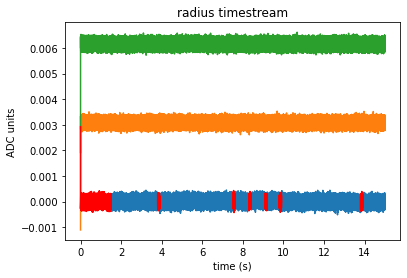

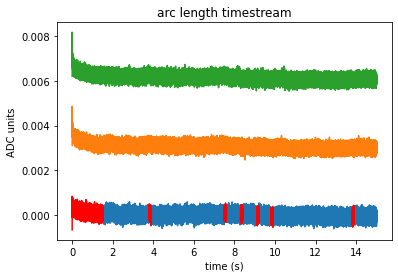

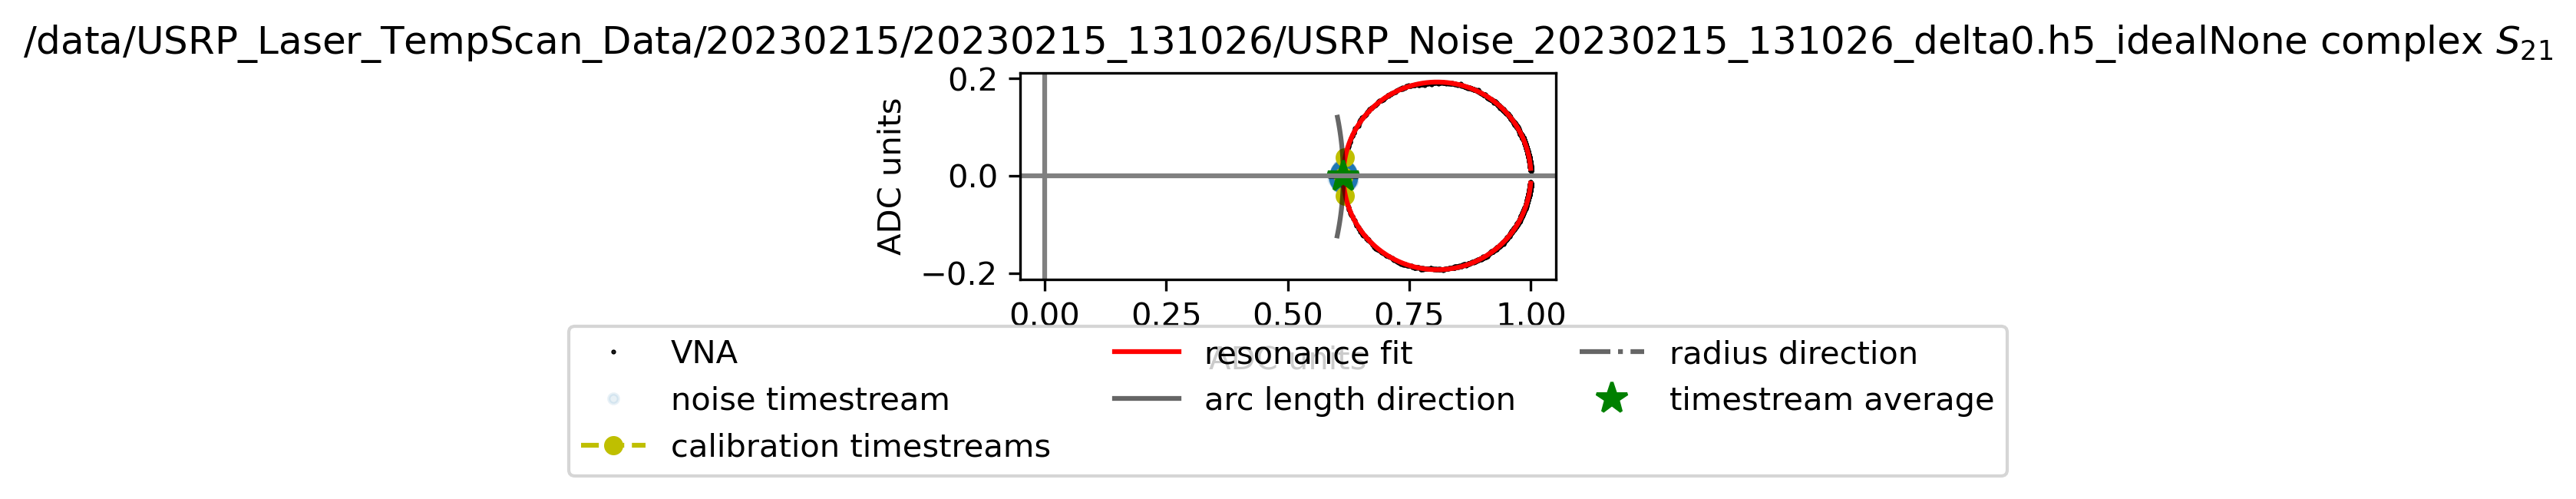

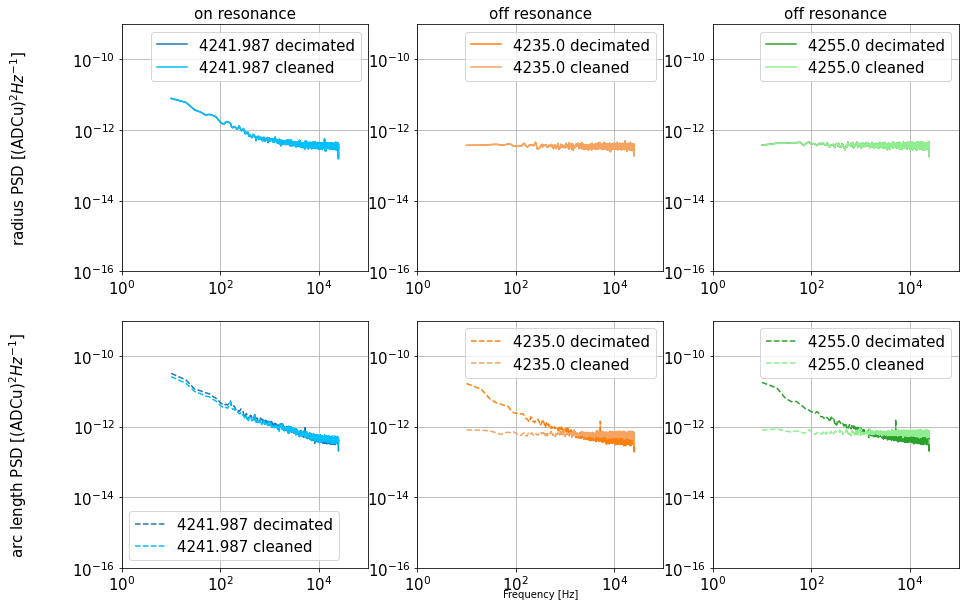

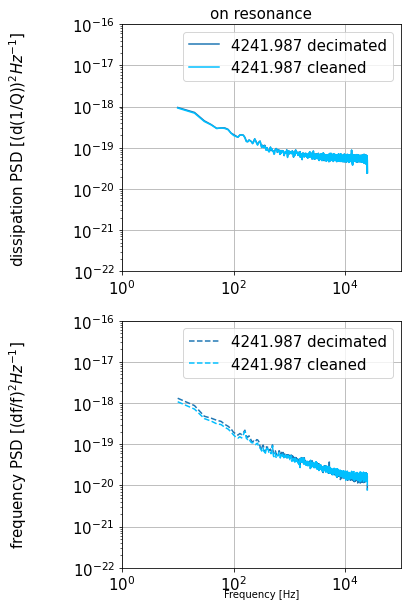

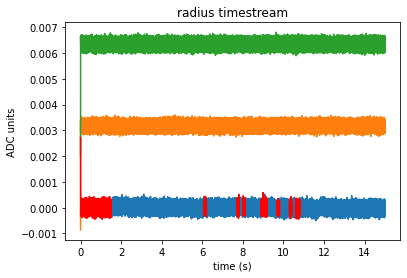

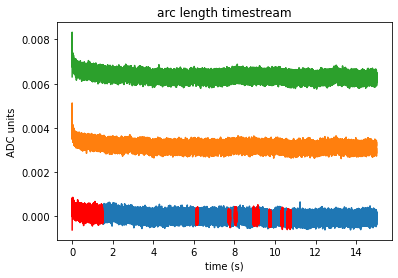

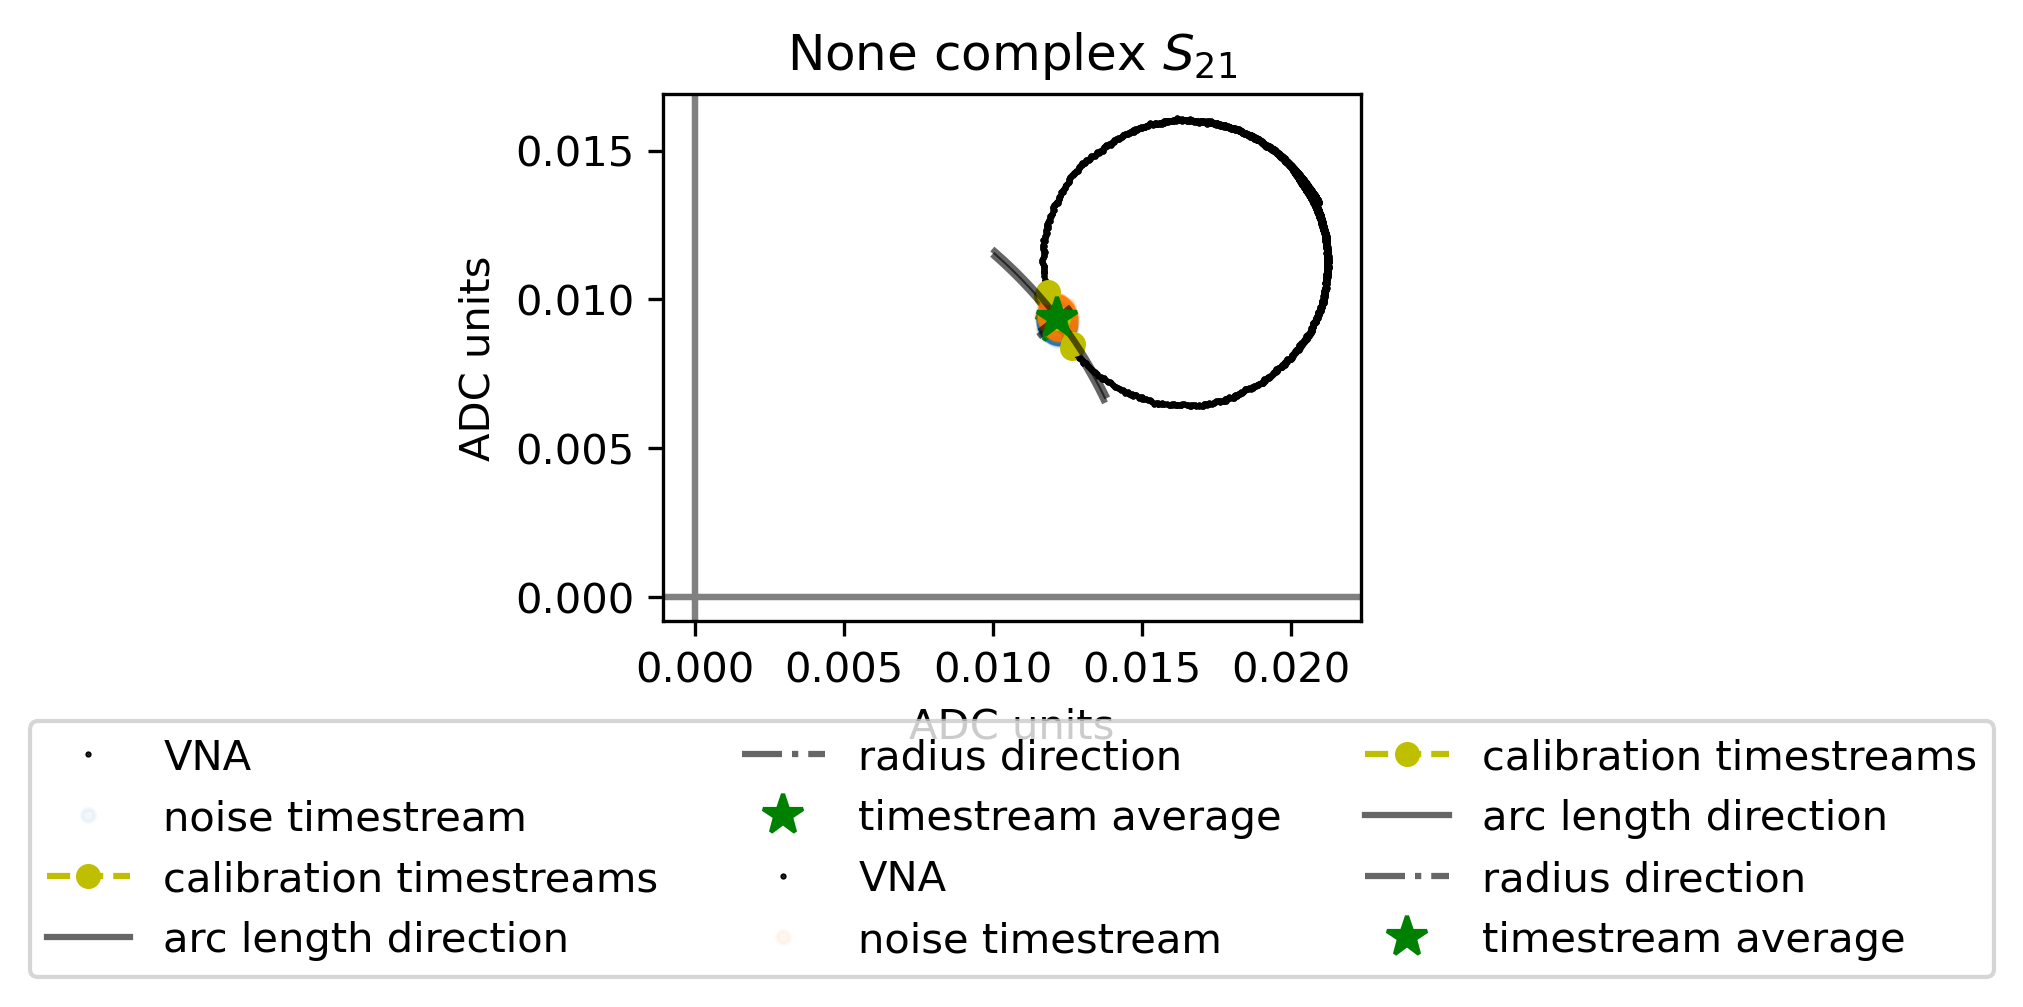

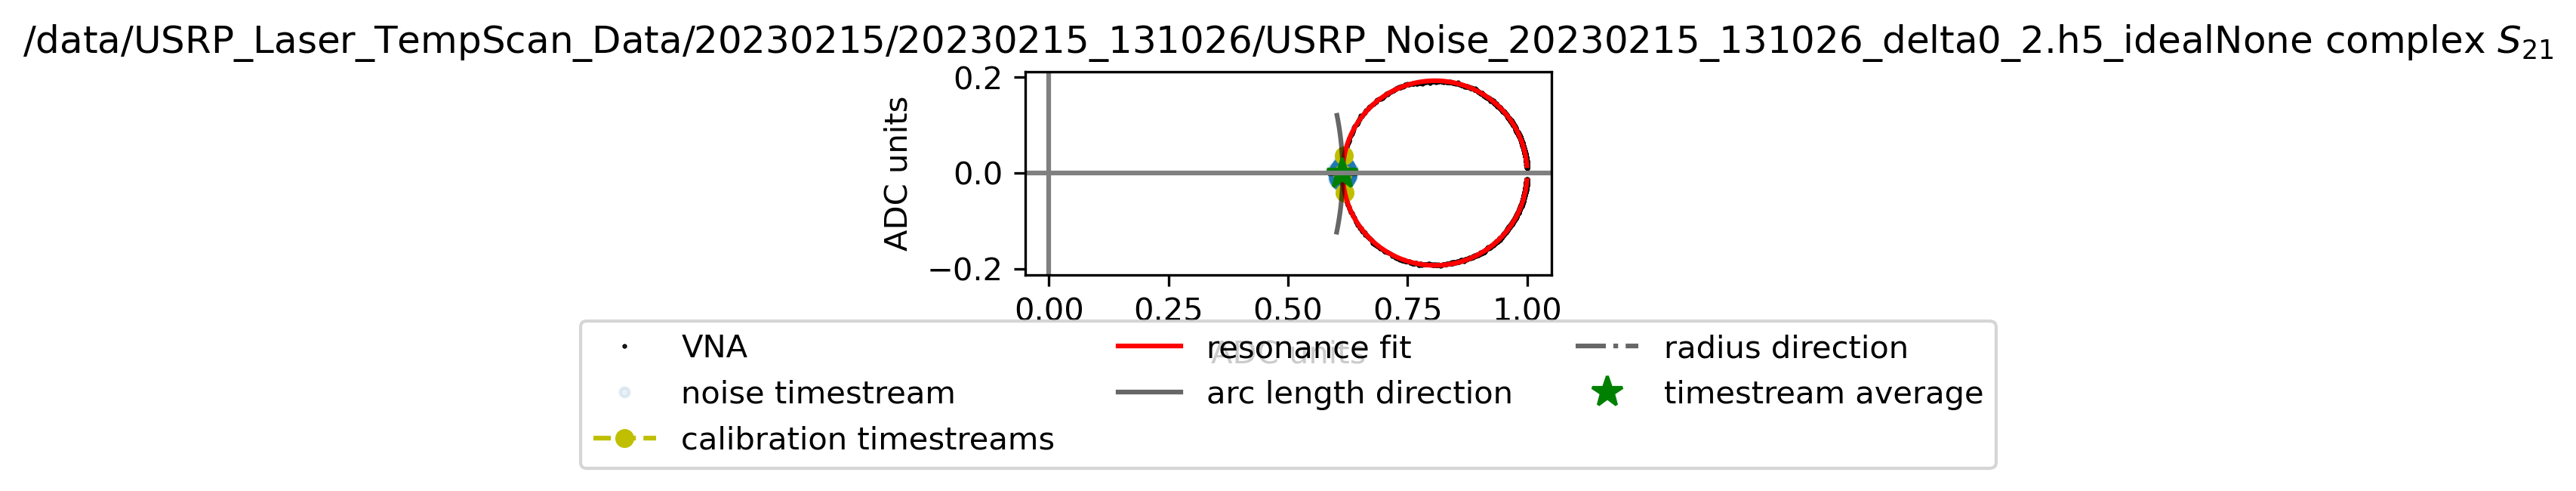

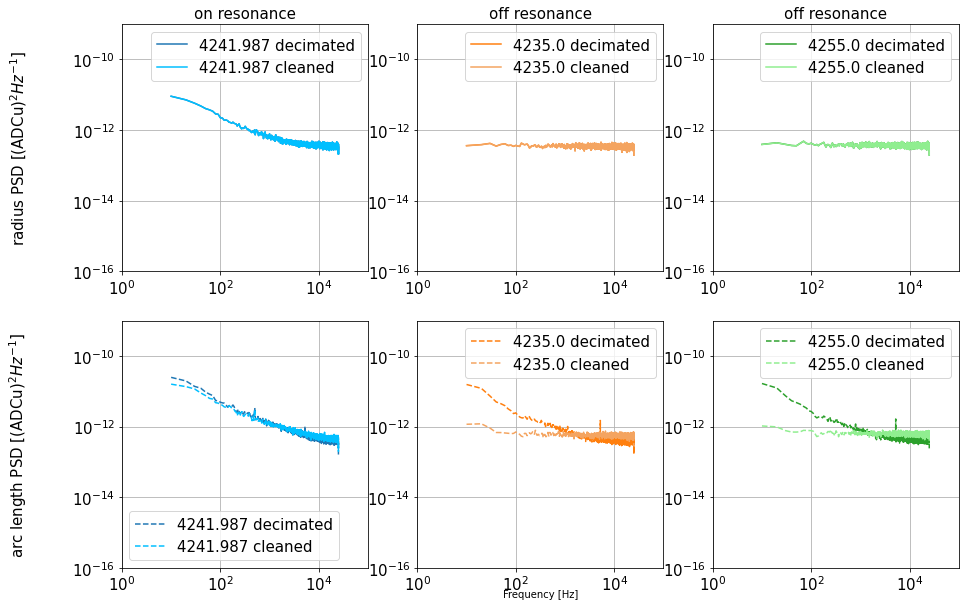

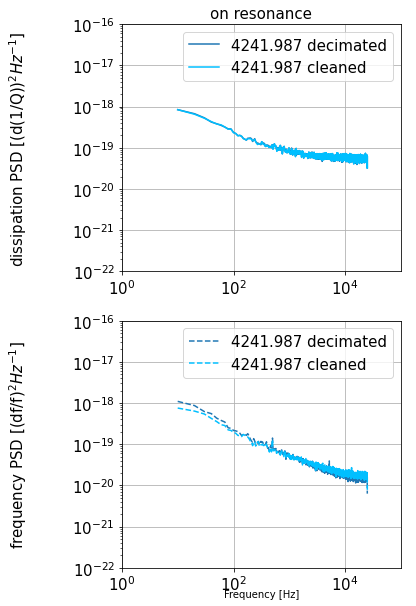

In [17]:
for i in np.arange(len(nse_files)):
    ## Do the cleaning of the noise file
    powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[i], vna_file, 
        PSD_lo_f=chunk_up_to, 
        PSD_hi_f=decimate_down_to, 
        rem_dec=10,
        f_transient=blank_fraction, 
        charFs=charFs[i].real, 
        charZs=charZs[i])

## Pick which files to scan

In [18]:
files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

LED_files = led_files[files_to_skip:n_runs-files_to_trim]
Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

# LED_files = LED_files[Voltages != 2.50]
# Voltages  = Voltages[ Voltages != 2.50]

for i in np.arange(len(LED_files)):
    print(LED_files[i],":",Voltages[i])

PHASE = True

/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_2.000V_20230215_131026.h5 : 2.0
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_3.000V_20230215_131026.h5 : 3.0
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_4.000V_20230215_131026.h5 : 4.0
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_5.000V_20230215_131026.h5 : 5.0


## Pulse window plotting and removal of bad windows

plotting pulse file: /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_2.000V_20230215_131026.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_VNA_20230215_131026.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_Noise_20230215_131026_delta0.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_3.000V_20230215_131026.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_VNA_20230215_131026.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_Noise_20230215_131026_delta0.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_4.000V_20230215_131026.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_VNA_20230215_131026.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_Noise_20230215_131026_delta

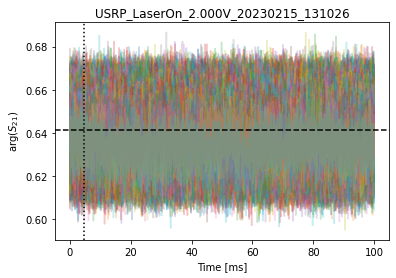

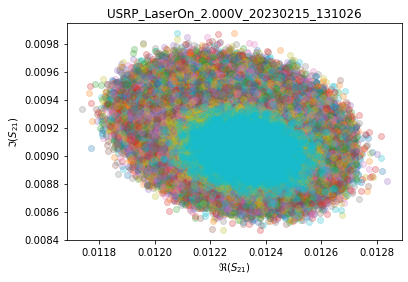

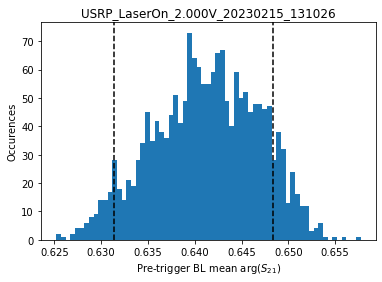

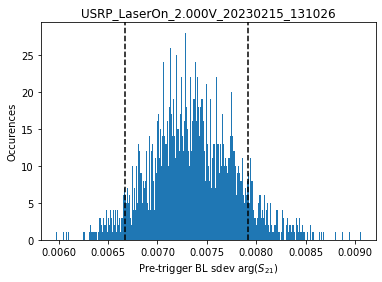

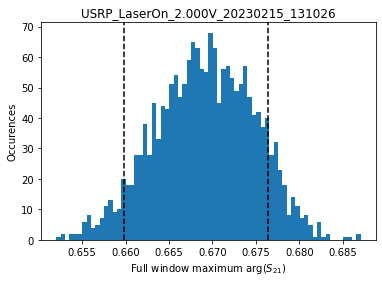

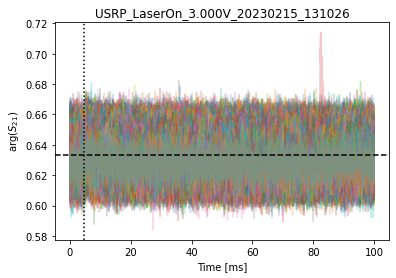

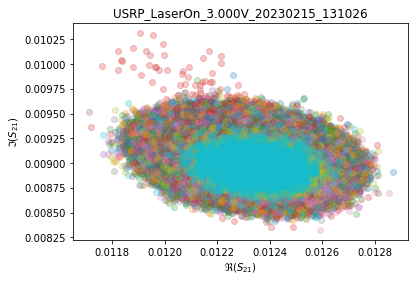

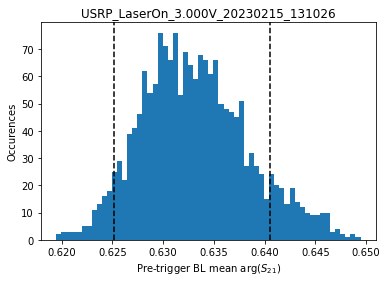

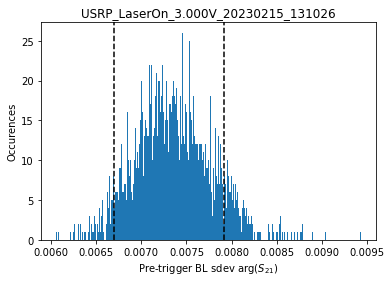

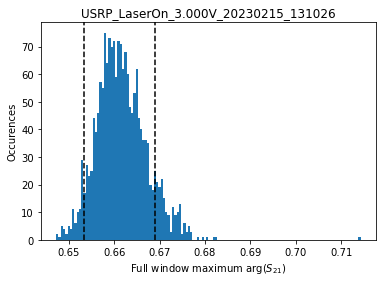

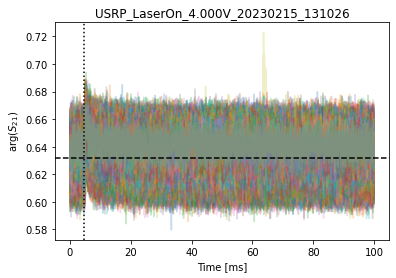

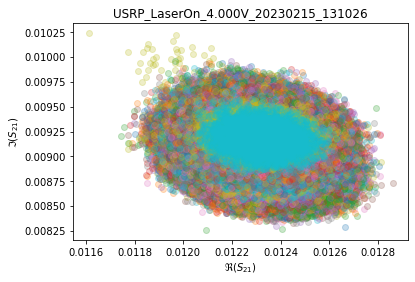

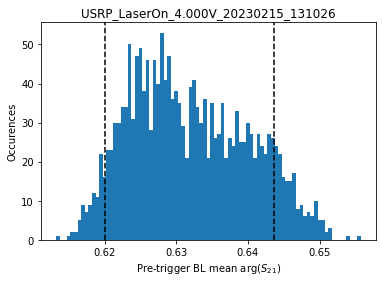

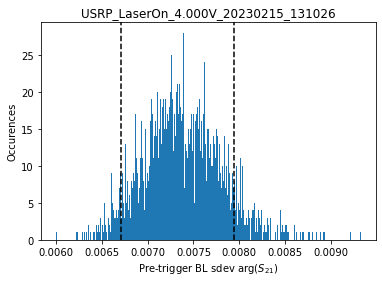

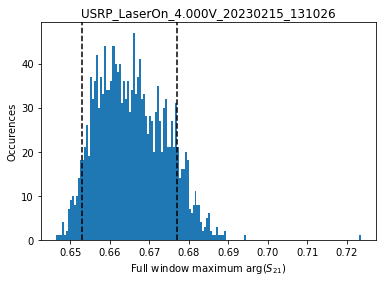

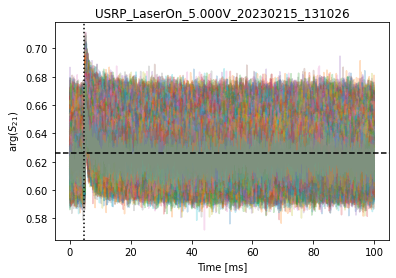

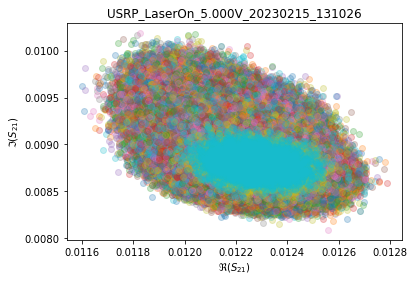

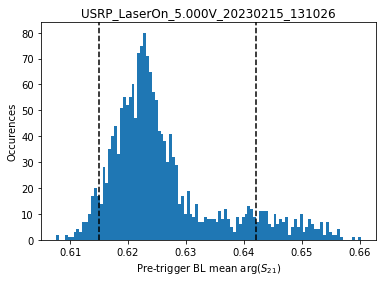

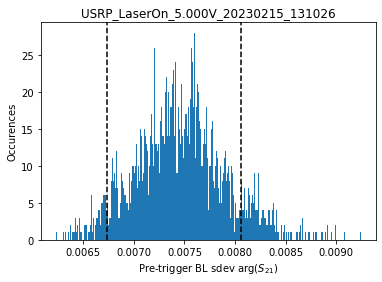

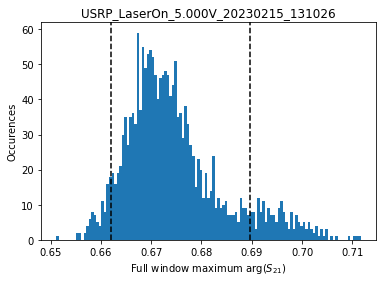

In [19]:
show_plots = True

## Window selection
pretrig_seconds = (delay_ms-0.25)*1e-3
p1 = 5 ; p2 = 90

## Create dictionaries to store the cut criteria parameters
mean_dict = {}
sdev_dict = {}
maxv_dict = {}

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    print('===================')
    print('plotting pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = 4 # int(pulse_fs/decimate_down_to)

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation
    
    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse)-1
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulse windows
    pulse_start = int(total_pulses * blank_fraction)
    
    ## How many samples to shift the pulse window definition
    pretrig = int(pretrig_seconds * sampling_rate)
    
    ## Create an empty array to store our results in
    ## This is the average baseline of the three timestreams across all pulse windows
    noise_averages = 0 # np.zeros((3),dtype=np.complex128)
    
    ## Create empty arrays to store values which we will use to perform quality cuts
    ## These will have an entry for each pulse window
    bl_means = np.array([])#,dtype=np.complex128)
    bl_sdevs = np.array([])#,dtype=np.complex128)
    pls_maxs = np.array([])#,dtype=np.complex128)
    
    ## Create plots to store waveforms
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        if PHASE:
            ax0.set_ylabel(r"$\arg (S_{21})$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the edges of the pulse window
        pulse_idx_start = pulse_i_end - N
        pulse_idx_end   = pulse_i_end
        
        ## Grab the timestream in that region and average it
        full_pulse_chunk  = pulse_noise[pulse_idx_start:pulse_idx_end,:]
        pretrig_pls_chunk = pulse_noise[pulse_idx_start:pulse_idx_start+pretrig,:]
        
        ## Determine the two quadratures we care about
        phase  = np.angle(pretrig_pls_chunk[:,0])
        logmag = np.log10(abs(pretrig_pls_chunk[:,0]))
        
#         ## Calculate some means and stdevs of the pre-trigger region of this pulse window
#         m = np.mean(pretrig_pls_chunk,axis=0,dtype=np.complex128) ; bl_means = np.append(bl_means,m[0])
#         s = np.std( pretrig_pls_chunk,axis=0,dtype=np.complex128) ; bl_sdevs = np.append(bl_sdevs,s[0])
        
#         # Calculate the maximum point in the entire waveform
#         if PHASE:
#             x = np.max( np.angle(    full_pulse_chunk)  ,axis=0) ; pls_maxs = np.append(pls_maxs,x[0])
#         else:
#             x = np.max( np.log10(abs(full_pulse_chunk)) ,axis=0) ; pls_maxs = np.append(pls_maxs,x[0])
        
        ## Find the mean, sdev of pre-trigger window and maximum pulse height in full window
        if PHASE:
            m = np.mean(phase ) ; bl_means = np.append(bl_means,m)
            s = np.std( phase ) ; bl_sdevs = np.append(bl_sdevs,s)
            x = np.max(np.angle(full_pulse_chunk[:,0])) ; pls_maxs = np.append(pls_maxs,x)
        else:
            m = np.mean(logmag) ; bl_means = np.append(bl_means,m)
            s = np.std( logmag) ; bl_sdevs = np.append(bl_sdevs,s)
            x = np.max(np.log10(abs(full_pulse_chunk[:,0]))) ; pls_maxs = np.append(pls_maxs,x)
        
        ## Keep a running average of the baseline noise in pre-trigger region across all pulse regions
        noise_averages += m    
        
        ## Plot the full pulse window against time
        if show_plots:
            if PHASE:
                ax0.plot(t*1e3,np.angle(full_pulse_chunk[:,0]),alpha=0.25)
            else:
                ax0.plot(t*1e3,np.log10(abs(full_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(full_pulse_chunk[:,0].real,full_pulse_chunk[:,0].imag,alpha=0.25)
        
        ## Increment the good pulse counter
        k += 1
    
    ## Average the baseline mean over every pulse window
    noise_averages /= k
    
    ## Save the cut criteria to our dictionaries
    mean_dict[pulse_file] = bl_means
    sdev_dict[pulse_file] = bl_sdevs
    maxv_dict[pulse_file] = pls_maxs
         
    ## Draw some lines to mark the pulse window regions
    if show_plots:
        if PHASE:
#             ax0.axhline(y=np.angle(noise_averages[0]),color="k",ls='--')
            ax0.axhline(y=noise_averages,color="k",ls='--')
        else:
#             ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
            ax0.axhline(y=noise_averages,color="k",ls='--')
        ax0.axvline(x=pretrig_seconds*1e3,color="k",ls=':')
    
    ## Create plots that inform our cuts
    if show_plots:
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        ax2.hist(bl_means, 
             bins=np.arange(
                 start = np.min( bl_means ) ,
                 stop  = np.max( bl_means ) + 5e-4,
                 step  = 5e-4))
        ax2.axvline(x=np.percentile(bl_means,p1), color="k",ls='--')
        ax2.axvline(x=np.percentile(bl_means,p2), color="k",ls='--')
        if PHASE:
            ax2.set_xlabel(r"Pre-trigger BL mean $\arg(S_{21})$")
        else:
            ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        ax3.hist(bl_sdevs, 
             bins=np.arange(
                 start = np.min( bl_sdevs ) ,
                 stop  = np.max( bl_sdevs ) + 1e-5,
                 step  = 1e-5))
        ax3.axvline(x=np.percentile(bl_sdevs,p1), color="k",ls='--')
        ax3.axvline(x=np.percentile(bl_sdevs,p2), color="k",ls='--')
        if PHASE:
            ax3.set_xlabel(r"Pre-trigger BL sdev $\arg(S_{21})$")
        else:
            ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi4 = plt.figure(pulse_file+"_e")
        ax4 = fi4.gca()
        ax4.hist(pls_maxs, 
             bins=np.arange(
                 start = np.min( pls_maxs ) ,
                 stop  = np.max( pls_maxs ) + 5e-4 ,
                 step  = 5e-4))
        ax4.axvline(x=np.percentile(pls_maxs,p1), color="k",ls='--')
        ax4.axvline(x=np.percentile(pls_maxs,p2), color="k",ls='--')
        if PHASE:
            ax4.set_xlabel(r"Full window maximum $\arg(S_{21})$")
        else:
            ax4.set_xlabel(r"Full window maximum $\log_{10}(|S_{21}|)$")
        ax4.set_ylabel("Occurences")
        ax4.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

## Define the Cuts

In [23]:
## Define a file path and name where cut limits will be stored
save_path = "/".join(LED_files[0].split("/")[:5])
save_name = series + "_bl_cutvals" 
save_key  = series+"_cuts"
if PHASE:
    save_name += "_phase" 
    save_key  += "_phase"

force_save = False

## Check if cuts already exist
if ( os.path.exists(os.path.join(save_path,save_name+".h5")) ) and not force_save:
    cut_df = pd.read_hdf(os.path.join(save_path,save_name+".h5"), key=save_key)
    save_cuts = False
elif ( os.path.exists(os.path.join(save_path,save_name+".csv")) ) and not force_save:
    cut_df = pd.read_csv(os.path.join(save_path,save_name+".h5"))
    save_cuts = False
else:
    save_cuts = True
    print("Saving new cut definitions to:",save_name)
    
    ## Create a pandas dataframe for the cut limits
    cut_df = pd.DataFrame(index=LED_files,columns=None)

    ## Define the columns we'll use to store cut limits
    cut_df["sdev_min"] = np.ones(len(LED_files))
    cut_df["sdev_max"] = np.ones(len(LED_files))
    cut_df["mean_min"] = np.ones(len(LED_files))
    cut_df["mean_max"] = np.ones(len(LED_files))
    cut_df["wfmx_min"] = np.array([None] * len(LED_files))
    cut_df["wfmx_max"] = np.array([None] * len(LED_files))

    ## Now populate each row in the dataframe

#     ## Default Cuts
#     for _i in np.arange(len(LED_files)):
#         cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p1)
#         cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p2)
#         cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p1) 
#         cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p2) 
#         cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7400
    
    ## 2.00 V
    _i = 0
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6550
    
    ## 3.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.70
    
    ## 4.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.70
    
    ## 5.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(mean_dict[LED_files[_i]],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.63 # np.percentile(mean_dict[LED_files[_i]],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(sdev_dict[LED_files[_i]],p2) 
#     cut_df["wfmx_max"].loc[LED_files[_i]] = 0.70
    
    if (save_cuts or force_save):
        print("Saving cuts to file", os.path.join(save_path,save_name))
        cut_df.to_hdf( os.path.join(save_path,save_name+".h5") , save_key)
        cut_df.to_csv( os.path.join(save_path,save_name+".csv"))
        
cut_df

Saving new cut definitions to: 20230215_131026_bl_cutvals_phase
Saving cuts to file /data/USRP_Laser_TempScan_Data/20230215/20230215_131026/20230215_131026_bl_cutvals_phase


/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/share/anaconda3/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '20230215_131026_cuts_phase'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['wfm

,sdev_min,sdev_max,mean_min,mean_max,wfmx_min,wfmx_max
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_2.000V_20230215_131026.h5,0.006674,0.007917,0.631349,0.648391,None,None
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_3.000V_20230215_131026.h5,0.006698,0.007911,0.625169,0.640533,None,0.7
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_4.000V_20230215_131026.h5,0.006707,0.007941,0.620020,0.643586,None,0.7
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_5.000V_20230215_131026.h5,0.006735,0.008062,0.615056,0.630000,None,None


## Apply the Cuts

In [24]:
## Create a dictionary that will contain arrays of bad pulse indeces
bad_pls_idxs = {}

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    
    ## Extract the cut criteria limits
    bl_mean_min = cut_df["mean_min"].loc[pulse_file]
    bl_mean_max = cut_df["mean_max"].loc[pulse_file]
    bl_sdev_min = cut_df["sdev_min"].loc[pulse_file]
    bl_sdev_max = cut_df["sdev_max"].loc[pulse_file]
    wf_max__min = cut_df["wfmx_min"].loc[pulse_file]
    wf_max__max = cut_df["wfmx_max"].loc[pulse_file]
    
    ## Extract the cut criteria dictionaries
    bl_means = mean_dict[pulse_file]
    bl_sdevs = sdev_dict[pulse_file]
    pls_maxs = maxv_dict[pulse_file]
    
    ## Create an empty array for the bad pulse indeces
    bad_pulses = np.array([])
    
    ## Loop over pulse windows
    for k in np.arange(len(bl_means)):
        
        ## Check the cuts for baseline mean
        if (bl_means[k] < bl_mean_min) or (bl_means[k] > bl_mean_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check the cuts for baseline sdev
        if (bl_sdevs[k] < bl_sdev_min) or (bl_sdevs[k] > bl_sdev_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        if wf_max__max is not None:
            if (pls_maxs[k] > wf_max__max):
                bad_pulses = np.append(bad_pulses, k)
                continue
                
        if wf_max__min is not None:
            if (pls_maxs[k] < wf_max__min):
                bad_pulses = np.append(bad_pulses, k)
                continue
    
    bad_pls_idxs[pulse_file] = bad_pulses
    print(pulse_file, ":", len(bad_pulses), "bad pulses")


/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_2.000V_20230215_131026.h5 : 503 bad pulses
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_3.000V_20230215_131026.h5 : 500 bad pulses
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_4.000V_20230215_131026.h5 : 508 bad pulses
/data/USRP_Laser_TempScan_Data/20230215/20230215_131026/USRP_LaserOn_5.000V_20230215_131026.h5 : 680 bad pulses


## Pulse cleaning

In [ ]:
show_plots = True

## Options
verbose = False 

## Window selection for pulse-free region
window_shift_seconds = 0 # -8.0e-3
frac_to_keep = 0.1

j = 0
for pulse_file in LED_files:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(np.round(pulse_fs/decimate_down_to))

    if verbose:
        print('loaded pulse data')

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation

    if verbose:
        print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(frac_to_keep * samples_per_pulse) ## We look at the second half of a pulse window only
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    time = 1e3*(time_btw_pulse-t[::-1])
    
    if verbose:
        print("Sampling rate:",sampling_rate,"per sec")
        print("Samples per pulse window:",samples_per_pulse)
        print("N=:",N,"; T=",T,";",np.shape(f))
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulses
    pulse_start = int(total_pulses * blank_fraction)
    if verbose:
        print("Starting pulse partitioning after", pulse_start, "windows (of",total_pulses,")")
    
    ## How many samples to shift the pulse window definition
    window_shift = int(window_shift_seconds * sampling_rate)
    if verbose:
        print("Shifting pulse window by", window_shift, "samples")
    
    ## Create empty arrays to store our results in
    noise_averages = np.zeros((3),dtype=np.complex128)
    J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
    
    ## Create empty arrays to store values for histograms
    bl_means = np.array([],dtype=np.complex128)
    bl_sdevs = np.array([])#,dtype=np.complex128)
    
    ## Create a plot to store waveforms
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

    ## Count how many good pulses there are
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region and average it
        no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
        
        ## Calculate some means and stdevs of this pulse-free timestream
        m = np.mean(no_pulse_chunk,axis=0,dtype=np.complex128) ; bl_means = np.append(bl_means,m[0])
        
        if PHASE:
            s = np.std( np.angle(    no_pulse_chunk[:,0])  ) ; bl_sdevs = np.append(bl_sdevs,s)
        else:
            s = np.std( np.log10(abs(no_pulse_chunk[:,0])) ) ; bl_sdevs = np.append(bl_sdevs,s)
        
        ## Keep a running average of the noise across all pulse regions
        noise_averages += m / n_good_pulses    
        
        ## Plot the pulse free region against time
        if show_plots: # and (k==0):
            ax0.plot(time, np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(no_pulse_chunk[:,0].real,no_pulse_chunk[:,0].imag,alpha=0.25)

        ## Convert to the electronics basis and compute the J objects
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
        
        ## Increment the counter
        k += 1
    
    if verbose:
        print("Searched",n_good_pulses,"pulse windows")
        print('used ' + str(n_good_pulses) + ' chunks to find quiescent point')
    
    if show_plots:
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
        
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        if PHASE:
            ax2.hist(np.angle(bl_means))
            ax2.set_xlabel(r"Pre-trigger BL mean $\arg(S_{21})$")
        else:
            ax2.hist(np.log10(abs(bl_means)))
            ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        if PHASE:
            ax3.hist(bl_sdevs)
            ax3.set_xlabel(r"Pre-trigger BL sdev $\arg(S_{21})$")
        else:
            ax3.hist(bl_sdevs)
            ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

    ## Pull the two real quantities from the complex timestream averages
    radius_averages = abs(noise_averages)
    angle_averages  = np.angle(noise_averages)
    if verbose:
        print(radius_averages)
        print(angle_averages)

    ## Rotate the timestream by the averange angle, then get the rotated phase timestream
    pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
    angle_timestream = np.angle(pulse_timestream_rotated)

    ## Subtract off the average magnitude value and calculate an arc length
    radius = abs(pulse_noise) - radius_averages
    arc    = angle_timestream*radius_averages

    ## Create output containers for the clean timestreams
    radius_clean = np.zeros(radius.shape)
    arc_clean    = np.zeros(arc.shape)

    if verbose:
        print('built radius and arc length timestreams given by quiescent point')
        print(noise_file)
        
    ## Pull the dictionary containing cleaning coefficients from the noise timestream
    _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

    ## Loop over each tone in the radius timestream
    for t in range(radius.shape[1]):
        ## Pull the coefficients from the noise cleaning
        radius_coefficient = data_info['radius cleaning coefficient'][t]
        arc_coefficient    = data_info['arc cleaning coefficient'][t]

        ## Clean each tone with the off-resonance tones
        if t == 0:
            off_tone_idcs = [1,2]
        elif t == 1:
            off_tone_idcs = [2]
        elif t == 2:
            off_tone_idcs = [1]

        ## Perform the radius cleaning
        off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
        radius_clean[:,t] = radius[:,t] - radius_coefficient*off_tone_radius

        ## Perform the arc length cleaning
        off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
        arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

        if verbose: 
            print('cleaned tone ' + str(t))

    ## Subtract off the mean from cleaned radius and arc length timestreams
    radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
    arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    
    ## Save the clean timestreams to a file
    pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                   radius_averages,\
                                                   angle_averages,\
                                                   radius_clean,\
                                                   arc_clean,\
                                                   sampling_rate,\
                                                   timestreams['radius coefficient'],\
                                                   timestreams['arc coefficient'],\
                                                   override=True)

    ## Calculate the PSDs for each of the cleaned pulses
    
    ## Create containers for our output PSDs
    J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
    
    ## Loop over pulses
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region
        no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

        ## Convert the pulse-free region to electronics basis
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        
        ## Compute the PSDs
        J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
        
        ## Increment the counter
        k += 1

    ## Trim the output to the positive frequency region only
    J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
    
    ## Every tenth files, show the PSDs
    if j % 1 == 0:
        print(pulse_file)
        fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
        
        Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                      ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                      data_freqs=pulse_info['search freqs'],\
                      P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                      fig_0=fig_0,axes_0=axes_0)

    j += 1

## Pulse averaging

In [ ]:
fraction_to_keep = 0.5 # 1.0 # 0.5 # (5.0/12.5) # 1.0
window_shift_seconds = 0 # 5.0e-3
verbose = False

j = 0 
for pulse_file in LED_files:
    
    ## Get the VNA data for this set of runs
    f,z = PUf.read_vna(vna_file)

    print('===================')
    print('averaging pulse file: ' + pulse_file)

    ## Load the clean pulse data
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
    if verbose: 
        print('loaded clean pulse data')        
        print('sampling_rate: ' + str(data_info['sampling_rate']))
    
    ## Determine how many samples are in each pulse window
    samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

    ## Do extra decimation if needed (1 = no decimation) 
    decimation = 1
    time = Prf.average_decimate(pulse_info['time'],decimation)
    pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
    
    ## Update the samples per window and sampling rate with new decimation
    samples_per_pulse_decimated = int(samples_per_pulse / decimation)
    sampling_rate = data_info['sampling_rate'] / decimation
    if verbose:
        print('further decimation by ' + str(decimation) + ' complete')

    ## Create a container to store our average pulse in complex S21 for this file
    pulse_avg    = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
    
    ## Determine how many samples to shift the window by
    window_shift = int(window_shift_seconds*sampling_rate)
    
    ## Identify the first pulse window after the transient period
    pulse_start  = int(total_pulses * blank_fraction)
    
    ## Count how many good pulses there are in this file
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue

        ## Define the sample index where this pulse window ends
        pulse_idx_start = int((pulse_i  )*samples_per_pulse_decimated) + window_shift
        # pulse_idx_end   = int((pulse_i+1)*samples_per_pulse_decimated) + window_shift -1
        pulse_idx_end   = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
        
        ## Create a list of indeces corresponding to the samples in this pulse window
        pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        
        ## Average the pulses in each good window
        pulse_avg += pulse_noise_clean[pulse_idx_list,0] / n_good_pulses
        
        ## Increment the counter
        k += 1
    
    ## Create a figure in complex S21 to show VNA, full timestream, and average pulse
    fig, axs = plt.subplots(1, 2)
    plt.suptitle(pulse_file.split("/")[-1])
    axs[0].set_xlabel(r"$\Re(S_{21})$")
    axs[0].set_ylabel(r"$\Im(S_{21})$")
    axs[1].set_xlabel("Time [ms]")
    if PHASE:
        axs[1].set_ylabel(r"$\arg (S_{21})$")
    else:
        axs[1].set_ylabel(r"$\log10 |S_{21}|$")
    
    axs[0].plot(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,ls='',marker='.',alpha=0.1,color='grey')
    axs[0].plot(pulse_avg.real,pulse_avg.imag,color='C'+str(j % 10),ls='-',marker='.')
    axs[0].plot(z.real,z.imag,color='k',ls='-',marker='.',alpha=1.00)
    
    if PHASE:
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.angle(pulse_noise_clean[pulse_idx_list,0]))
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.angle(pulse_avg))
    else:
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.log10(abs(pulse_noise_clean[pulse_idx_list,0])))
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.log10(abs(pulse_avg)))
    
    width = 50 * np.std(pulse_noise_clean[:,0].real)
    x_c = np.mean(pulse_avg.real)
    y_c = np.mean(pulse_avg.imag)
    axs[0].set_xlim([x_c - width/2., x_c + width/2.])
    axs[0].set_ylim([y_c - width/2., y_c + width/2.])
    axs[0].set_aspect('equal','box')
    
    plt.subplots_adjust(wspace=0.5)
    
    # plt.savefig('noise and averaged pulse.png',dpi=100)
        
    print('Used ' + str(n_good_pulses) + ' pulses to average')
    with h5py.File(clean_pulse_file, "a") as fyle:
        if 'pulse_shape' in fyle.keys():
            del fyle['pulse_shape']
            print('deleted an old pulse shape')
        fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
    j += 1

## Pulse rotation

In [ ]:
%matplotlib notebook

In [ ]:
## Initialize an index to count files as we loop
i = 0

## Define the time window for the pulse-full region, in microseconds
time_window_range = fraction_to_keep * time_btw_pulse *1e6
time_window = np.arange(0,time_window_range,1/sampling_rate*1e6)#[:-1]

## Define the time window in microseconds that will be used to align the pulses later
tw_min =  8000 # 200 # 3000 # 
tw_max = 10000 # 300 # 4000 # 
# time_window = np.arange(-200,time_window_range-200,1/sampling_rate*1e6)
# time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)

## Create some strings to use as plot titles and handles later
AWF_string = str(int(10*pulse_w)/10) + " us"
title_1    = 'power ' + str(rf_power) + '; AWF ' + AWF_string + ': pulses in S21'
title_1p5  = 'power ' + str(rf_power) + '; AWF ' + AWF_string + ': pulses in S21, zoomed in'
title_1p75 = 'alignment of pulses using largest pulse (blue)' 
title_2    = 'S_21 pulse height along pulse alignment axis'

## Pull the readout frequency from the characterization data
## then get the VNA data for this run
readout_f = charFs[0,1].real
f,z = PUf.read_vna(vna_file)

## Loop over the full list of LED files (the reversed order is no longer important)
for pulse_file in LED_files[::-1]:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using summary file: ',sum_file)
    char_file = sum_file

    ## Get the cleaned data and average pulse
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
        pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)

    ## Get the timestreams and average pulse in resonator basis
    df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,charFs[0].real*1e-3,charZs[0])#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
    df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,charFs[0].real*1e-3,charZs[0])
    # plt.axis([0.058, 0.062, -0.19, -0.15])
    
    ## Get the timestreams and average pulse in quasiparticle basis
    dk1, dk2, =                       Prf.quasiparticle_basis(df_f, d1_Q,
                                                              data_T     = 10.0e-3, 
                                                              MB_results = MB_fit_vals,
                                                              readout_f  = readout_f*1e-3)
    dk1_timestream, dk2_timestream, = Prf.quasiparticle_basis(df_f_timestream, d1_Q_timestream,
                                                              data_T     = 10.0e-3, 
                                                              MB_results = MB_fit_vals,
                                                              readout_f  = readout_f*1e-3)

    ## Baseline(mean)-subtract the average pulse, then find its stdev
    ## Using the last five samples of the average pulse to get mean, sdev
    pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
    std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
    
    ## Calculate the average angle of the average pulse in the specified alignment window
    average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>tw_min,time_window<tw_max)]))
    
    ## Baseline(mean)-subtract the (raw) pulse timestream for the on-resonance tone
    ## Again using the last five samples of the average pulse to get mean
    pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)

    ## Apply the rotation by the average angle to the baseline-subtracted timestream and average pulse
    pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
    pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)

    ## Define the pulse template we want to use and which timestream to use it on
    ## Also subtract the baseline of the template to make sure baseline=0 for optimal filtering
    
    ## == CHOOSE ONE TO DO ANALYSIS == ##
    
    ## Fractional change in frequency 
#     template = df_f - np.mean(df_f[:20])
#     noise = df_f_timestream - np.mean(df_f[:20])
#     ylbl  = r"Frequency Shift $\delta f / f$"

    ## Dissipation direction quasiparticle basis
    template = dk2 - np.mean(dk2[:20])
    noise = dk2_timestream - np.mean(dk2[:20])
    ylbl  = r"Dissipation qp shift $\delta \kappa_2$ [$\mu$m$^{-3}$]"

    # template = pulse_avg_rotated.real
    # noise = pulse_timestream_rotated.real
    # print(np.shape(pulse_avg),np.shape(df_f))

    ## Open the clean data file and save the template and noise
    with h5py.File(clean_pulse_file, "a") as fyle:
        print("Saving clean pulse file:",clean_pulse_file)
        if 'df_f_template' in fyle.keys():
            del fyle['df_f_template']
        if 'df_f_pulse_noise' in fyle.keys():
            del fyle['df_f_pulse_noise']
        fyle.create_dataset('df_f_template',data = np.asarray(template))
        fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
    
    ## Define some labels to add to plots
    label_c = 'characterization data' if i == 0 else None
    label_V = 'VNA' if i == 0 else None
    label_p = 'pulse data ' if i == 0 else None
    
    ## Grab the vna + average pulse plot, draw the vna, average pulse, and characterization data
    ## we only have to draw the VNA on the first file
    plt.figure(title_1)
    plt.title(title_1)
    plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
    # plt.plot(pulse_timestream[4:,0].real,pulse_timestream[4:,0].imag,ls='None',marker='.',color='C'+str(i%10),alpha=0.1)
    if i==0:
        plt.plot(z.real,z.imag,color='k',label=label_V)
    plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='-',label=label_c,zorder=-5*i+200)
    plt.axhline(0,color='grey')
    plt.axvline(0,color='grey')
    
    ## Adjust the plot limits
    width = np.std(pulse_avg.real) * 8e3
    x_c = np.mean(pulse_avg.real)
    y_c = np.mean(pulse_avg.imag)
    plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
    plt.gca().set_aspect('equal','box')
    plt.legend()

    ## Grab the zoomed-in vna + average pulse plot, draw the vna, average pulse, and characterization data
    ## we only have to draw the VNA on the first file
    plt.figure(title_1p5)
    plt.title(title_1p5)
    plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
    # if i==7:
    #     plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='k',label=label_p,zorder=-5*i+200)
    #     plt.plot(pulse_timestream[:,0].real,pulse_timestream[:,0].imag,ls='None',marker='.',color='C'+str(i%10),alpha=0.01)
    if i==0:
        plt.plot(z.real,z.imag,color='k',label=label_V)
    # plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
    
    ## Use the first file to set the extent of the zoomed-in plot
    if i == 0:
        width = 150 * np.std(pulse_avg.real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])

    ## Grab the average pulse rotation plot
    plt.figure(title_1p75)
    plt.title(title_1p75)
    plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
    plt.gca().set_aspect('equal', 'box')
    
    ## Grab the average pulse timestream plot and draw the timestream of the average pulse
    plt.figure(title_2)
    plt.xlabel('microseconds')
    plt.ylabel(ylbl)
    plt.title(title_2)
    plt.plot(time_window,template,ls='-',marker='.',markersize=5,color='C'+str(i))

    ## Increment our file counter
    i += 1
    
## Grab the zoomed-in vna + average pulse plot
plt.figure(title_1p5)

## Loop over the noise files again
for ai in np.arange(len(nse_files)):
    ## Get the noise timestream and average
    frequencies_scanned, noise_mean_scanned = PUf.avg_noi(nse_files[ai],time_threshold=30.0*blank_fraction)
    ## Draw the points
    plt.plot(noise_mean_scanned[0].real,noise_mean_scanned[0].imag,marker='*',markersize=10,markeredgecolor='k',ls='None',color='y',zorder=-5*i+200,alpha=ai*.2,label="Noise Averages")

plt.legend()

## Optimal Filter code

### OF Window parameter definitions

In [ ]:
## Number of seconds by which to shift the window when calculating J
window_shift_J = 0 # -8.0e-3 # -10e-6 #

## Define a maximum frequency for the fourier-space mask
f_max = 1e4 ## Hz maximum freq in fourier space

## Create titles for the plots
title      = 'readout power ' + str(rf_power) + ': '

## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

### Determine the signal template

In [ ]:
use_fit_as_template = False

## Pick the highest LED voltage data to use as signal template
pls_file_template = LED_files[-1]
print("Using file:",pls_file_template,"as pulse template")

## Find the clean pulse file, use the last one in the set that's been analyzed so far
clean_pulse_file = pls_file_template[:-3] + '_cleaned.h5'

## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
with h5py.File(clean_pulse_file, "r") as fyle:
    sampling_rate = np.array(fyle['sampling_rate'])
    pulse_avg     = np.array(fyle["df_f_template"])

## Determine a window size equivalent to the full pulse template window
N = len(pulse_avg)
print(N, "samples per window")

## Determine total period of the template and create a time-domain array and a freq-domain array
T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

## Define an offset function to recenter the pulse
t_offset = lambda N: int( (delay_ms*1e-3) * sampling_rate)
# t_offset = lambda N: int(N * (2*delay_ms*1e-3/time_btw_pulse) / frac_to_keep)

## Define an exponential function
exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],0.5) * A * np.exp(-1*(x-time[t_offset(N)])/tau)
dbl_expA    = lambda x, A, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * A * ( np.exp(-1*(x-time[t_offset(N)])/t1) + np.exp(-1*(x-time[t_offset(N)])/t2) )
# dbl_expB    = lambda x, A1, A2, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * ( A1*np.exp(-1*(x-time[t_offset(N)])/t1) + A2*np.exp(-1*(x-time[t_offset(N)])/t2) )

# ## Fit the average pulse to an exponential (in df/f)
# popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0e-7,       1.24e-3])
# popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0e-7,       1.24e-3/5.,1.24e-3*5.])
# # popt3,pcov3 = curve_fit(dbl_expB,time,pulse_avg   ,p0=[2.5e-7,2.5e-7,1.24e-3/5.,1.24e-3*5.])
# # Aweights = ( popt3[0]/(popt3[0]+popt3[1]) , popt3[1]/(popt3[0]+popt3[1]) )
# # print(weights)

## Fit the average pulse to an exponential (in k2)
popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0,       1.24e-3])
popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0,       1.24e-3/5.,1.24e-3*5.])
    
## Calculate the best fit curve for the average pulse
pulse_fit  = exponential(time,*popt)
pulse_fit2 = dbl_expA(time,*popt2)
# pulse_fit3 = dbl_expB(time,*popt3)
    
## Get the frequency space of the average pulse
# s_temp = Prf.discrete_FT(pulse_avg)
    
## Numerically integrate the fit, then FT it
if use_fit_as_template:   
    A = np.trapz(pulse_fit,dx = time[1]-time[0])
    s = Prf.discrete_FT(pulse_fit)
else:
    A = np.trapz(pulse_avg,dx = time[1]-time[0])
    s = Prf.discrete_FT(pulse_avg)

## Define a mask for evaluating fourier space components
f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
N_mask = len(f[f_mask])
f_plot = np.logical_and(f > 0, f <= f_max)
new_fs = max(f[f_mask])

## Get the magnitude of s^2 for the masked region
S_mag = abs(s[f_mask]**2)

## Create a plot to store the template waveform and best fit
f1p5  = plt.figure()
ax1p5 = f1p5.gca()
ax1p5.plot(time*1e3,pulse_fit, 'C7',linewidth=3,label='time constant: {:.2e}ms'.format(popt[-1]*1e3), ls='--' )
# ax1p5.plot(time*1e3,pulse_fit3,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
ax1p5.plot(time*1e3,pulse_fit2,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
ax1p5.plot(time*1e3,pulse_avg, label="Average pulse")
ax1p5.axhline(y=0,color='r',ls='--')
ax1p5.set_title(title + 'signal pulse timestream and fit')
ax1p5.set_xlabel("Time [ms]")
ax1p5.set_ylabel(ylbl)
# ax1p5.set_ylabel(r"Dissipation $\delta \kappa_2$ [$\mu$m$^{-3}$]")
plt.legend()

f1p7  = plt.figure()
ax1p7 = f1p7.gca()
ax1p7.plot(time*1e3,pulse_fit -pulse_avg,'C7',linewidth=3,label=r'$\tau=$ {:.2e}ms'.format(popt[-1]*1e3) , ls='--' )
# ax1p7.plot(time*1e3,pulse_fit3-pulse_avg,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
ax1p7.plot(time*1e3,pulse_fit2-pulse_avg,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
ax1p7.axhline(y=0,color='r',ls='--')
ax1p7.set_title(title + 'fit residuals')
ax1p7.set_xlabel("Time [ms]")
ax1p7.set_ylabel("Fit residual")
plt.legend()